In [2]:
import pandas as pd 
import numpy as np 
from os.path import join as os_join
import json
import os
import pprint
import matplotlib.pyplot as plt
import pickle
pp = pprint.PrettyPrinter(width=41, compact=True)
# white, professional/manager, US vs non-US, workclass (gov vs private)


# 0. Model input:
```
x = ['Sex=M', 'LabCount_total', 'LabCount_months', 'DrugCount_total','DrugCount_months', 'no_Claims', 'no_Providers', 'no_Vendors','no_PCPs', 'PayDelay_total', 'PayDelay_max', 'PayDelay_min',
'AgeAtFirstClaim=0-9', 'AgeAtFirstClaim=10-19', 'AgeAtFirstClaim=20-29','AgeAtFirstClaim=30-39', 'AgeAtFirstClaim=40-49','AgeAtFirstClaim=50-59', 'AgeAtFirstClaim=60-69','AgeAtFirstClaim=70-79', 'AgeAtFirstClaim=80+', 'AgeAtFirstClaim=?']

y = [ is_max_CharlsonIndex_greater_than_0 ]

```

This dataset has 3 types of input features
```
Binary, whether it's male
    - Sex=M
Continous vars, normalized to [0,1]
    - ['LabCount_total', 'LabCount_months', 'DrugCount_total', 'no_PCPs', 'PayDelay_total', 'PayDelay_max', 'PayDelay_min']
One-hot vars
    - ['AgeAtFirstClaim=0-9', 'AgeAtFirstClaim=10-19', 'AgeAtFirstClaim=20-29', 'AgeAtFirstClaim=30-39', 'AgeAtFirstClaim=40-49','AgeAtFirstClaim=50-59', 'AgeAtFirstClaim=60-69', 'AgeAtFirstClaim=70-79', 'AgeAtFirstClaim=80+', 'AgeAtFirstClaim=?']

Binary label,
is_max_CharlsonIndex_greater_than_0: 1 means "sick".
```



# 1. Data distribution

X_train set: (124086, 22)
X_dev set: (26590, 22)
X_test set: (26590, 22)


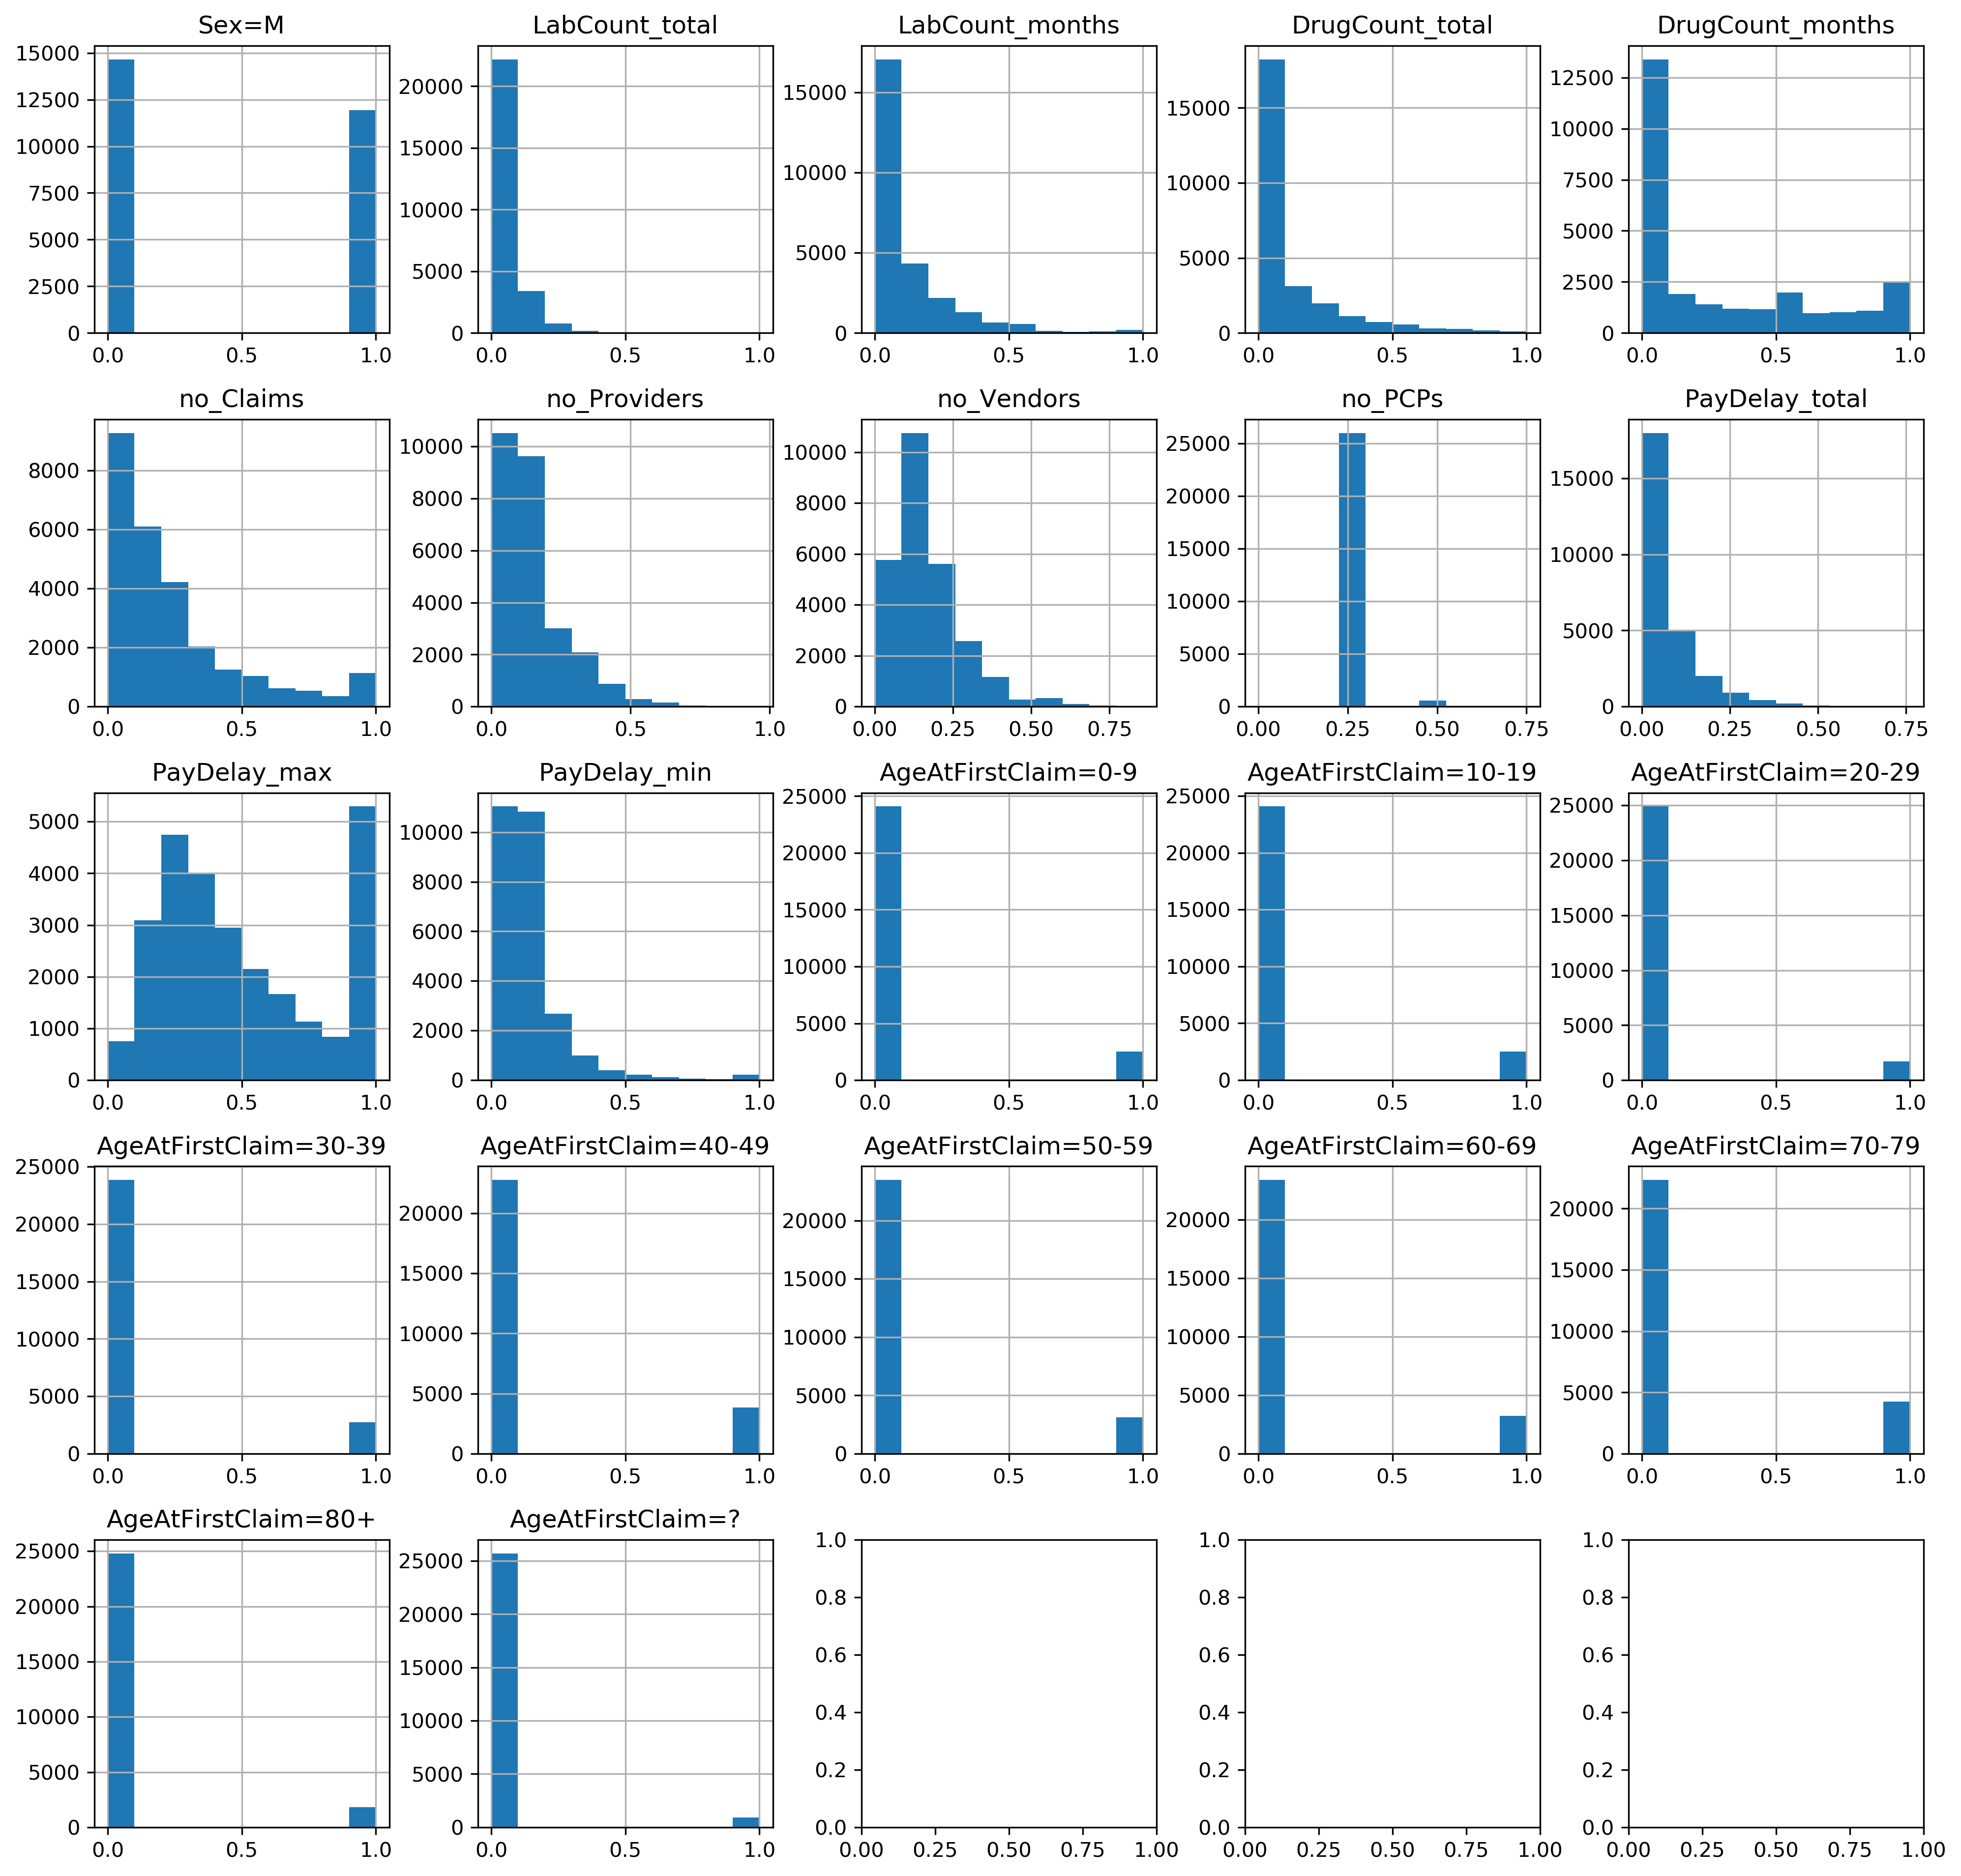

In [13]:
    
cache_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/cache'
random_seed = 0
cache_file_path = os_join(cache_path,f'np-health-data-rs={random_seed}.pkl')
with open(cache_file_path, 'rb') as f:
    data_dict = pickle.load(f)
X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_dev = data_dict["X_dev"]
y_dev = data_dict["y_dev"]
X_test = data_dict["X_test"]
y_test = data_dict["y_test"]
input_shape = X_train.shape[1]
print('X_train set:', X_train.shape)
print('X_dev set:', X_dev.shape)
print('X_test set:', X_test.shape)

# testing data distribution:

df_test  = pd.DataFrame(data = X_test, columns = ['Sex=M', 'LabCount_total', 'LabCount_months', 'DrugCount_total','DrugCount_months', 'no_Claims', 'no_Providers', 'no_Vendors','no_PCPs', 'PayDelay_total', 'PayDelay_max', 'PayDelay_min',
'AgeAtFirstClaim=0-9', 'AgeAtFirstClaim=10-19', 'AgeAtFirstClaim=20-29','AgeAtFirstClaim=30-39', 'AgeAtFirstClaim=40-49','AgeAtFirstClaim=50-59', 'AgeAtFirstClaim=60-69','AgeAtFirstClaim=70-79', 'AgeAtFirstClaim=80+', 'AgeAtFirstClaim=?'])


fig, axs = plt.subplots(5,5,figsize=(16, 16), dpi=300)
axs =  axs.flatten()[:22]
_ = df_test.hist(ax = axs)

# fig.tight_layout()



# 2. Load Model
### 1. Change res_root_path to the correct path, Something like: 
```
res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
```


In [8]:
res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'

In [5]:
def tell_me_model(random_seed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config):
    res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
    max_epoch = 10
    train_bs = 32
    # eval_bs = 128
    # lr = 0.01
    model_save_dir = os_join(res_root_path, f'health-model_config-{model_config}-max_epoch={max_epoch}-train_bs={train_bs}-random_seed={random_seed}-is_random_weight-{is_random_weight}-race_permute={is_race_permute}-sex_permute={is_sex_permute}-both_sex_race_permute={is_sex_race_both_permute}')
    onnx_file_path = os_join(model_save_dir, 'model.onnx')
    training_stats_file = os_join(model_save_dir, 'res-stats.json')
    # print (f'onnx is here: {onnx_file_path}' )
    # print (f'train-stats is here: {training_stats_file}' )
    
    with open(training_stats_file, 'r') as f:
        line = f.readline()
        train_stats = json.loads(line)
        # pp.pprint(train_stats)
    return [onnx_file_path], [train_stats]

def tell_me_model_aug_fair_train(random_seed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config):
    res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
    max_epoch = 10
    train_bs = 32
    # eval_bs = 128
    # lr = 0.01
    model_save_dir = os_join(res_root_path, f'health-model_config-{model_config}-max_epoch={max_epoch}-train_bs={train_bs}-random_seed={random_seed}-is_random_weight-{is_random_weight}-race_permute={is_race_permute}-sex_permute={is_sex_permute}'+
                                    f'-both_sex_race_permute={is_sex_race_both_permute}-is_fair_rmv_sym_diff={is_fair_train_remove_sym_diff}-is_fair_copy_sym_diff={is_fair_train_flip_duplicate_sym_diff}-is_fair_iter_copy_sym_diff={is_fair_train_iter_flip_duplicate_sym_diff}')
    #onnx_file_path = os_join(model_save_dir, 'model.onnx')
    #training_stats_file = os_join(model_save_dir, 'res-stats.json')
    #print (f'onnx is here: {onnx_file_path}' )
    #print (f'train-stats is here: {training_stats_file}' )
    
    # with open(training_stats_file, 'r') as f:
    #     line = f.readline()
    #     train_stats = json.loads(line)
    #     pp.pprint(train_stats)
    training_stats_files = []
    
    onnx_file_path_list, train_stats_list = [], []
    for K in range(10):
        _ = os_join(model_save_dir, f'res-stats-iter-{K}.json')
        onnx_file = os_join(model_save_dir, f'model-iter-{K}.onnx')
        if os.path.exists(_) is not True:
            break 
        else:
            training_stats_files.append(_)
            onnx_file_path_list.append(onnx_file)
    # print (len(training_stats_files))
    
    for _ in training_stats_files:
        with open(_,'r') as f :
            data = json.loads(f.readline())
            train_stats_list.append(data)
    #print(train_data)
    return onnx_file_path_list, train_stats_list


# Fetch the trained models with performance (auc) during train/val/test

In [6]:

model_summary = []

model_configs = ['small','medium']
num_random_seed = 5 # only repeat for once 
for model_config in model_configs:
    # normal model
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        res_dict = {'strategy': 'original', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)
        

    # sex-permute only model
    is_race_permute = False 
    is_sex_permute =  True
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        res_dict = {'strategy': 'sex-permute', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)

    # remove sym diff instance
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    is_fair_train_remove_sym_diff = True
    is_fair_train_flip_duplicate_sym_diff = False
    is_fair_train_iter_flip_duplicate_sym_diff = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model_aug_fair_train(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config)
        res_dict = {'strategy': 'Rmv-SymDiff', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)

    # augment sym diff instance
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    is_fair_train_remove_sym_diff = False
    is_fair_train_flip_duplicate_sym_diff = True
    is_fair_train_iter_flip_duplicate_sym_diff = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model_aug_fair_train(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config)
        res_dict = {'strategy': 'Aug-SymDiff', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)



    # random model
    # is_race_permute = False 
    # is_sex_permute =  False
    # is_sex_race_both_permute = False
    # is_random_weight = True
    # for randseed in range(num_random_seed):
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)

    # sex-permute only model
    # is_race_permute = False 
    # is_sex_permute =  True
    # is_sex_race_both_permute = False
    # is_random_weight = False
    # for randseed in range(num_random_seed): 
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        
    # both-sex-race-permute only model
    # is_race_permute = False 
    # is_sex_permute =  False
    # is_sex_race_both_permute = True
    # is_random_weight = False
    # for randseed in range(num_random_seed): 
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
    
df_model_summary = pd.DataFrame.from_records(model_summary)
df_model_summary


,strategy,random_seed,model_size,onnx_list,model_stats
0,original,0,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.454640924930572...
1,original,1,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.470596313476562...
2,original,2,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.465927213430404...
3,original,3,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.459149479866027...
4,original,4,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.461203575134277...
5,race-permute,0,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.458186566829681...
6,race-permute,1,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.472323805093765...
7,race-permute,2,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.471831798553466...
8,race-permute,3,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.459811240434646...
9,race-permute,4,small,[/Users/xingzhiguo/Documents/git_project/NN-ve...,[{'train': {'loss_history': [0.461758255958557...


# Pick an index to plot train/val/testing curve

In [32]:
picked_index = 37# the second row from above table

_df_model = df_model_summary.iloc[picked_index]
model_files = _df_model['onnx_list']
train_stats = _df_model['model_stats']
print (model_files) # may have one, or more than one (k-iter for augmented based on SD)
print(train_stats) # may have one, or more than one (k-iter for augmented based on SD)

_df = pd.DataFrame.from_records(train_stats)
_df['test_auc'] = [_['auc_history'][0] for _ in _df['test']]
display_df = None
if 'num_train' in _df.columns:
    display_df = _df[['num_train','test_auc']]
else:
    display_df = _df[['test_auc']]
display_df

['/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-0.onnx', '/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-1.onnx', '/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-2.onnx', '/Users/xingzhi

,num_train,test_auc
0,30121,0.835102
1,31572,0.821858
2,34047,0.799700
3,35039,0.816134
4,36160,0.816841
5,39757,0.819494
6,45439,0.825899
7,49674,0.799748
8,51147,0.835404
9,53853,0.541039
